# Air transportation fare prediction

You’ve been hired by one of the top earning travel companies. 
They provided you this dataset that can be used to predict flight prices for different airlines and routes, which can be helpful for customers who are looking to book flights at the best possible prices.
The goal of this project is to **predict the prices of flights** given this information, which can be helpful for both customers and airlines in understanding the factors that affect flight prices and making informed decisions about booking flights.

We import the needed libraries.

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

We import the dataset and get rid of the index column.

In [2]:
with open("flight_dataset.csv") as x:
    ncols = len(x.readline().split(','))

df = pd.read_csv("flight_dataset.csv", usecols=range(1,ncols))

In order to know the dimensions of our dataset we use the function shape, that returns a tuple representing the dimensionality of the DataFrame df. 

It has **300153 observations and 11 columns**.

In [3]:
df.shape

(300153, 11)

## 1. Preprocess and clean the data, handling missing values and outliers as necessary.

### Missing values

Let's check for duplicate and nan values in the dataset.

In [4]:
df.isna().sum()

airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_city    0
class               0
duration            0
days_left           0
price               0
dtype: int64

In [5]:
df.duplicated().sum()

0

Our dataset has **no missing nor duplicated values**.

### Outliers

Let's check the **presence of outliers** in the prices.

To do this we visualize the box plot of the _price_ variable.

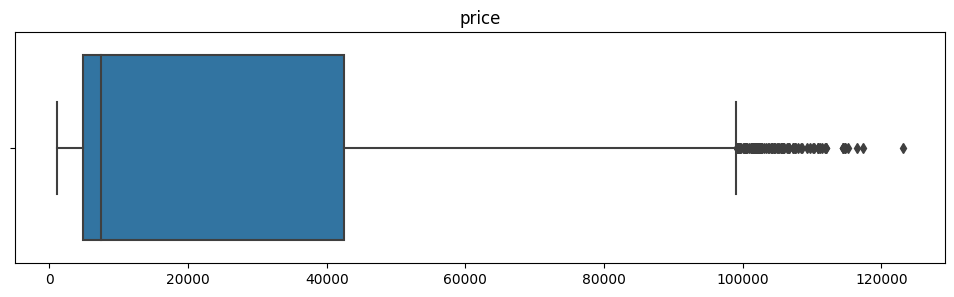

In [6]:
fig,axes=plt.subplots(figsize=(12, 3))
ax = sns.boxplot(x=df['price'].values).set_title('price')

We create a **function to remove outliers based on Interquartile Range (IQR)**. Then we apply it to our dataset. By doing this we **get rid of 123 observations**.

In [3]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_outl=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_outl

In [4]:
df_outlier_removed=remove_outlier_IQR(df.price)
df_outlier_removed=pd.DataFrame(df_outlier_removed)
ind_diff=df.index.difference(df_outlier_removed.index)

for i in range(0, len(ind_diff),1):
    df =df.drop([ind_diff[i]])

In [9]:
df.shape[0]

300030

In [10]:
#how many outliers have been detected with the interquartiale range?
len(ind_diff)

123

If we visualize again the initial boxplot we can see the new data.

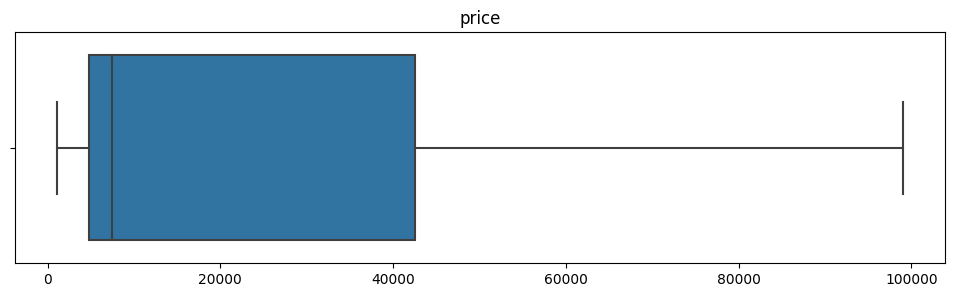

In [11]:
fig,axes=plt.subplots(figsize=(12, 3))
ax = sns.boxplot(x=df['price'].values).set_title('price')

#### CLEAN THE DATA 
- transform **duration in minutes**

Our data, before any manipulation, look like this.

In [12]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,2.17,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,2.33,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,2.17,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,2.25,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,2.33,1,5955


Let's first transform the duration (originally in hours) into minutes

In [5]:
df['duration'] = df.duration.astype(str)
def clean_duration(duration):
    duration = list(duration)
    duration_hours = []
    duration_mins = []
    for i in range(len(duration)):
        duration_hours.append(int(duration[i].split('.')[0]))
        duration_mins.append(int(duration[i].split('.')[1].split()[-1]))

    d = []
    for i in range(len(duration)):
        d.append(duration_hours[i]*60+duration_mins[i])
    return d 
df['duration'] = clean_duration(df['duration'])

Let's give again a look at the first rows of the dataset: we can see that now duration is correclty given in minutes.

In [14]:
df.head()

,airline,flight,source_city,departure_time,stops,arrival_time,destination_city,class,duration,days_left,price
0,SpiceJet,SG-8709,Delhi,Evening,zero,Night,Mumbai,Economy,137,1,5953
1,SpiceJet,SG-8157,Delhi,Early_Morning,zero,Morning,Mumbai,Economy,153,1,5953
2,AirAsia,I5-764,Delhi,Early_Morning,zero,Early_Morning,Mumbai,Economy,137,1,5956
3,Vistara,UK-995,Delhi,Morning,zero,Afternoon,Mumbai,Economy,145,1,5955
4,Vistara,UK-963,Delhi,Morning,zero,Morning,Mumbai,Economy,153,1,5955


# 2. Perform an Exploratory data analysis (EDA) with visualization using the entire dataset.

#### Discuss correlations and how the data is distributed. 
- Eventually remove highly correlated variables

#### How our variables relate to price


### Correlation Matrix using dython

Let's explore pairwise correlation.

To do this, we have used the dython.nominal.associations function in dython, that calculates the **correlation of features in data-set with both categorical and continuous features** using: 
-  Pearson's R for continuous-continuous cases 
-  Correlation Ratio for categorical-continuous cases 
-  Cramer's V for categorical-categorical cases

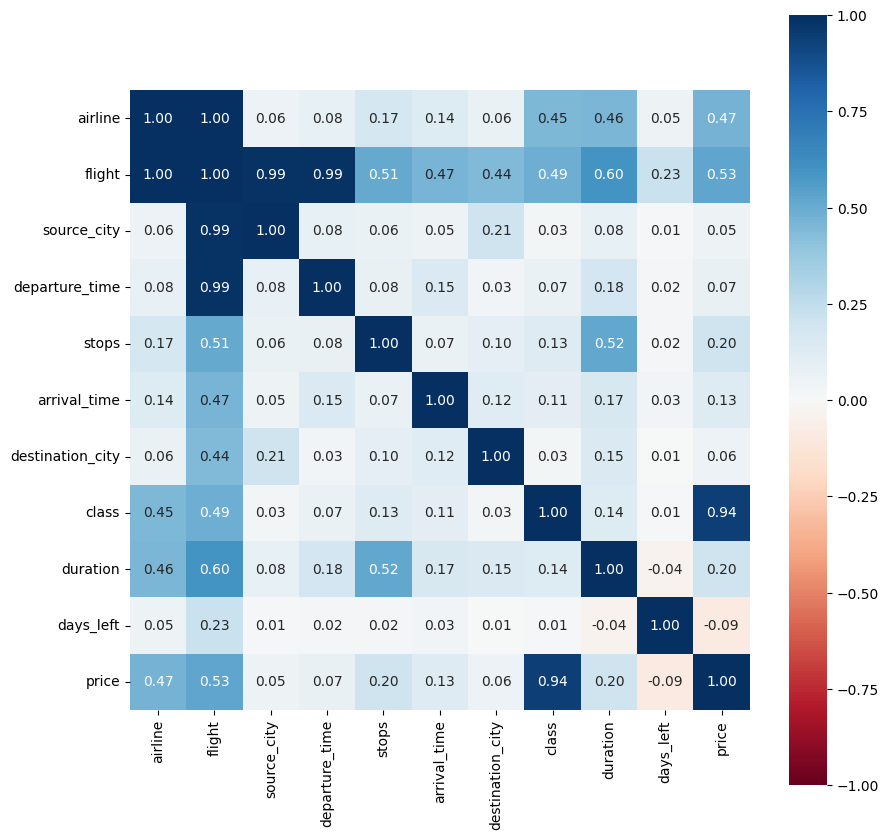

In [15]:
from dython.nominal import associations

complete_correlation= associations(df, filename= 'complete_correlation.png', figsize=(10,10), cmap="RdBu")

### Variables distribution

- Check the **distribution of the categorical variables**

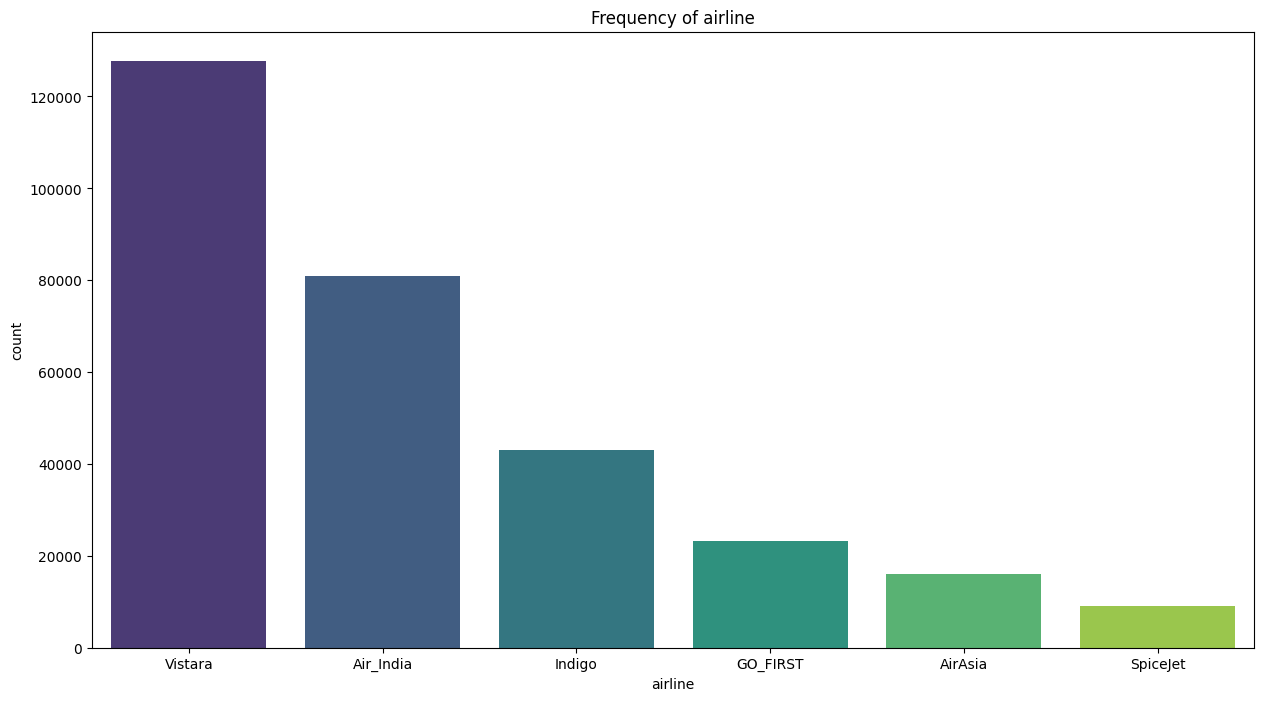

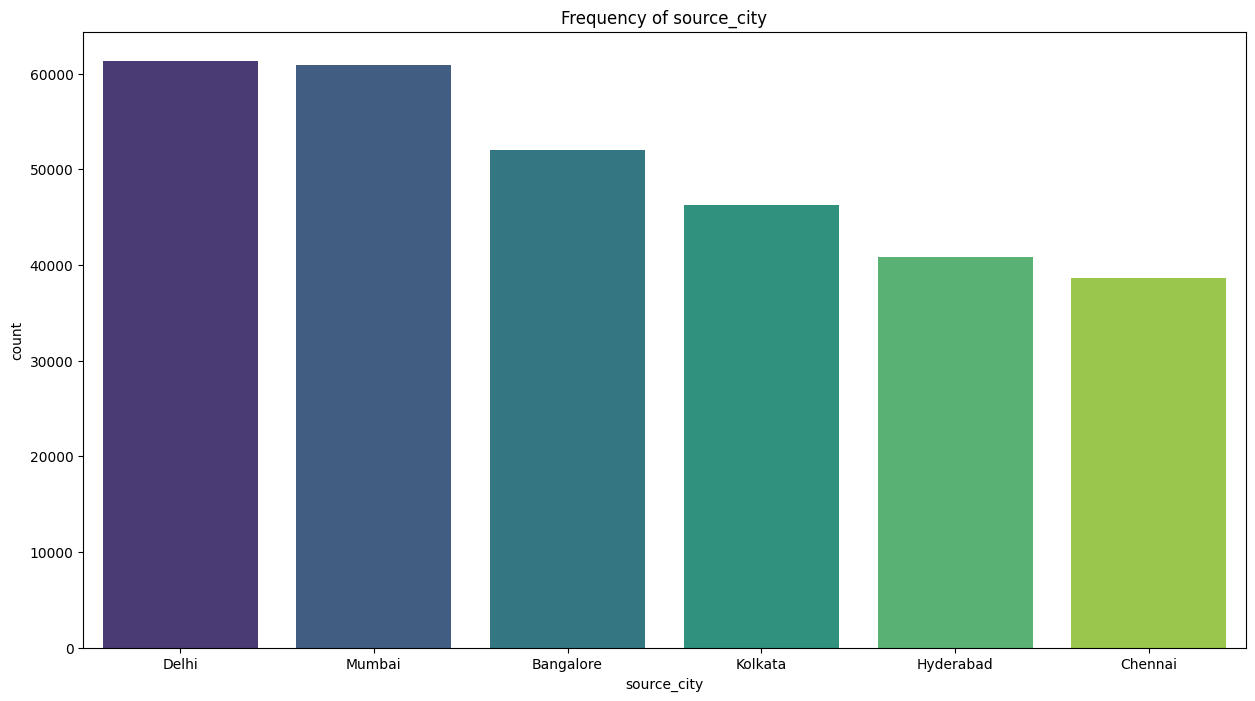

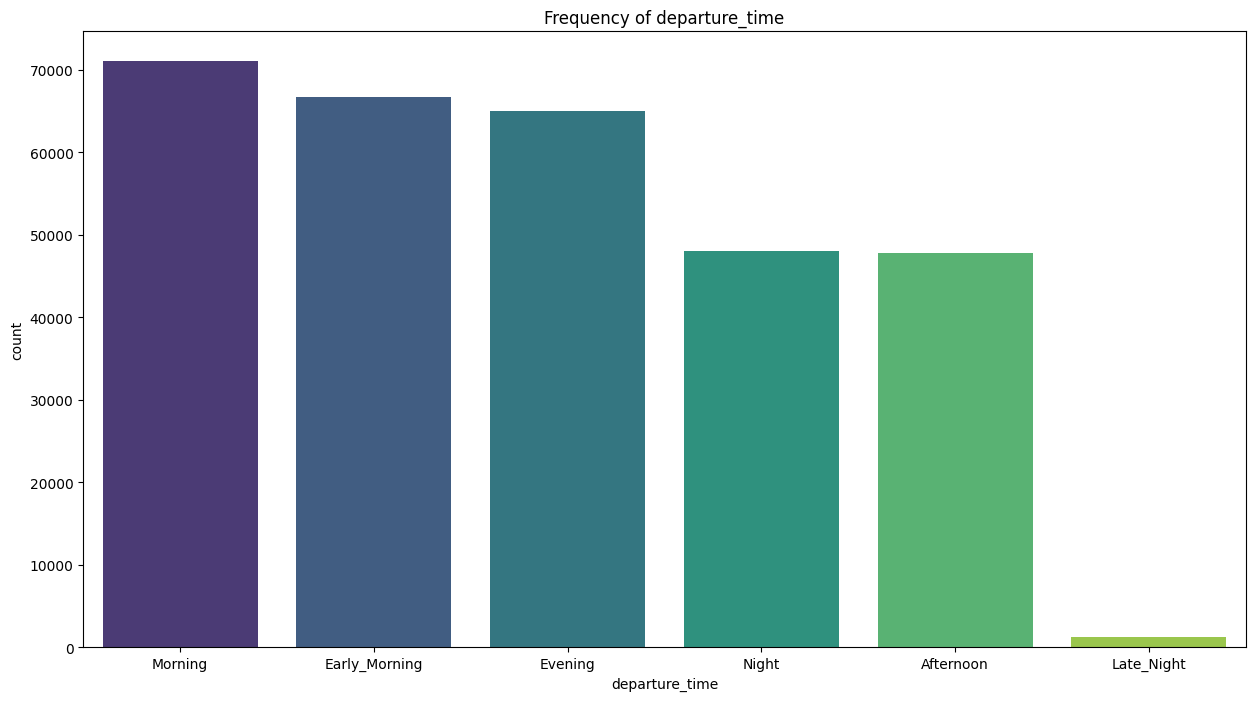

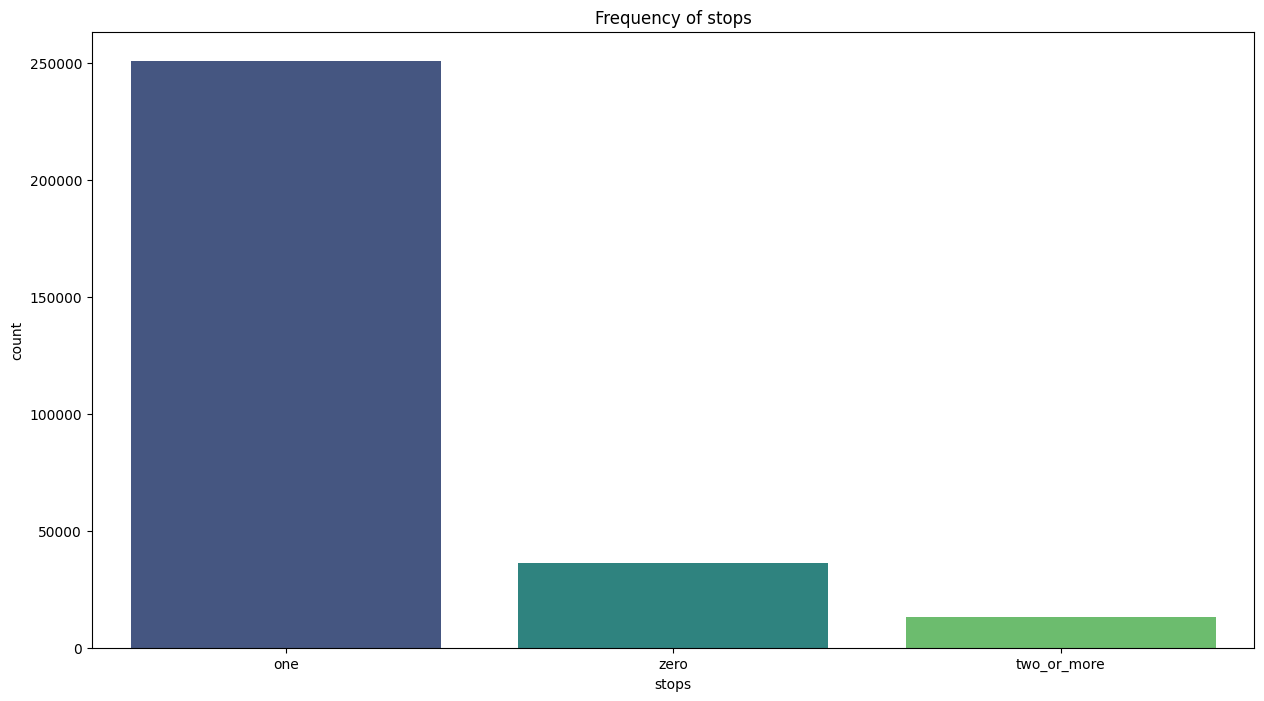

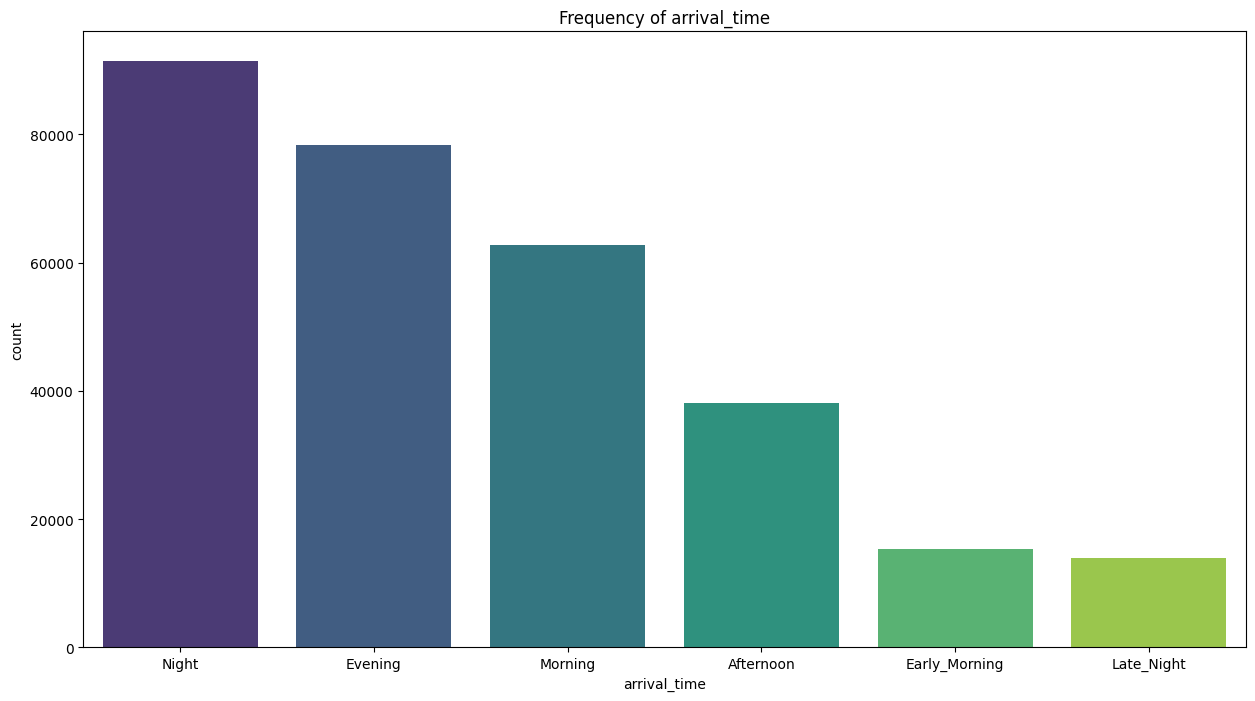

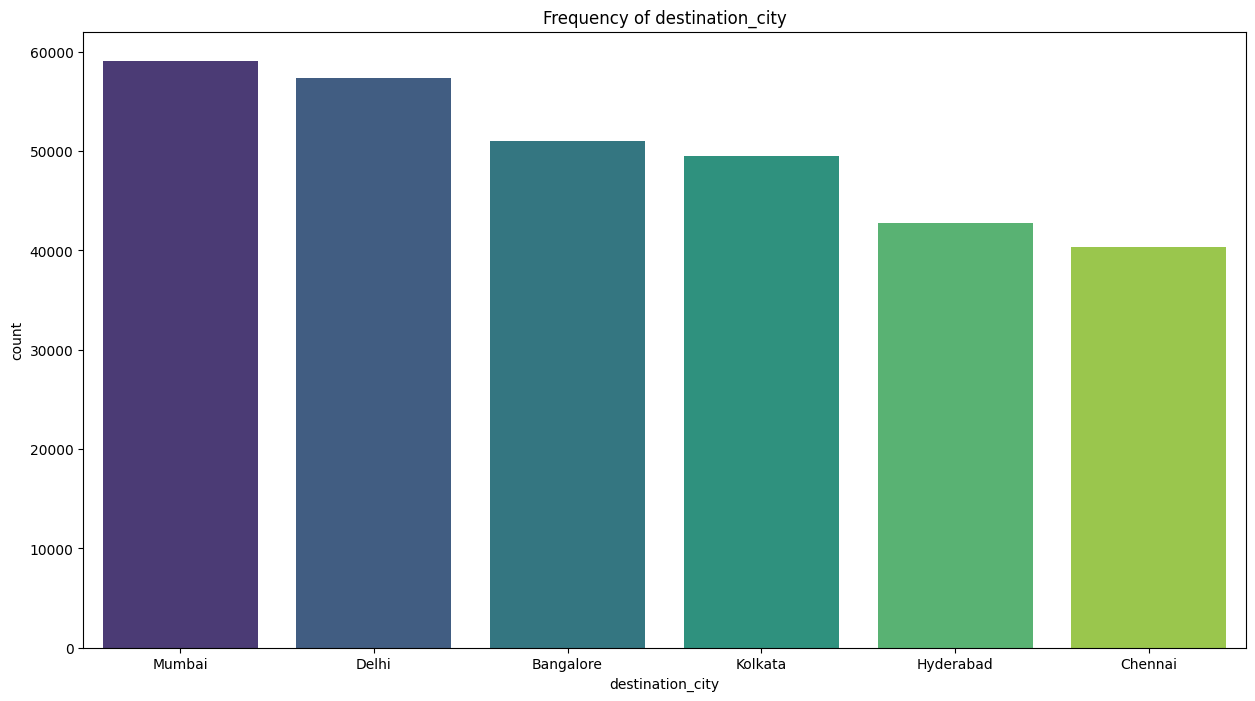

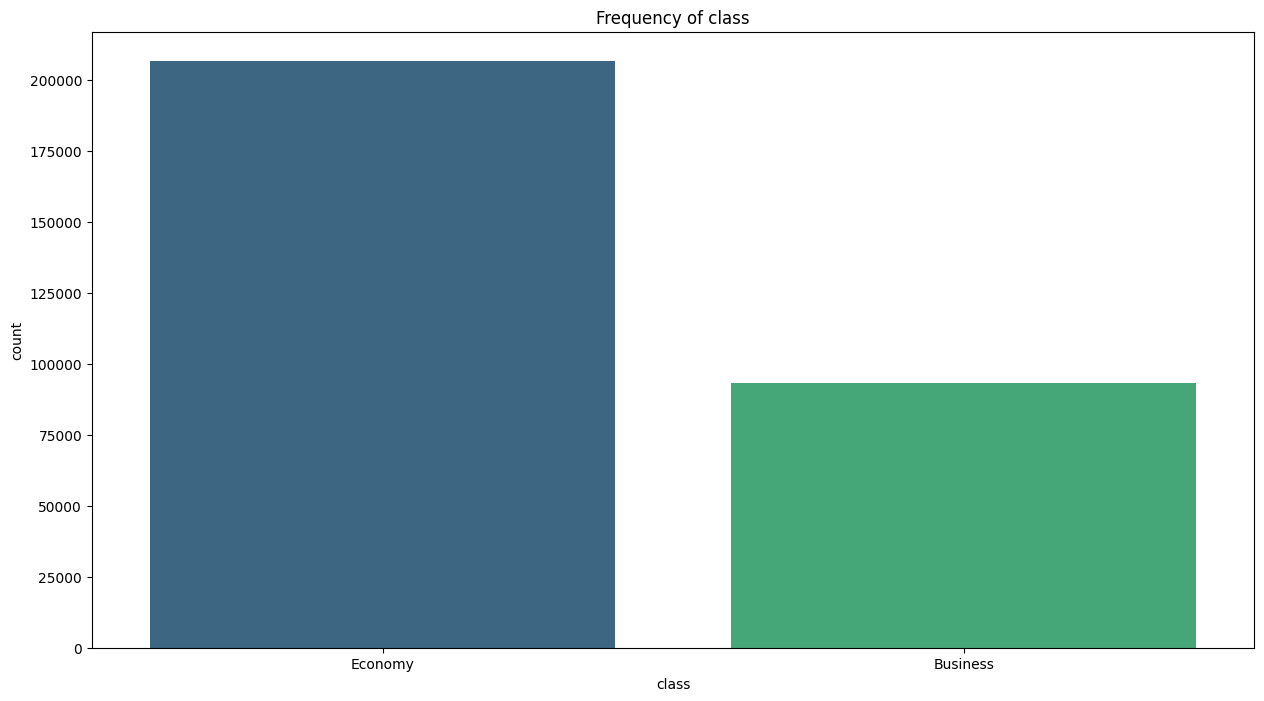

In [19]:
categorical = df.select_dtypes(include=['object']).columns
i = 0
for column in categorical: 
    plt.figure(figsize=(15,8))
    sns.countplot(x=df[column], data=df, palette='viridis', order = df[column].value_counts().index)
    plt.title(f"Frequency of {column}")
    plt.show()

- Check the **distribution of the numerical variables**

array([[<Axes: title={'center': 'duration'}>,
        <Axes: title={'center': 'days_left'}>],
       [<Axes: title={'center': 'price'}>, <Axes: >]], dtype=object)

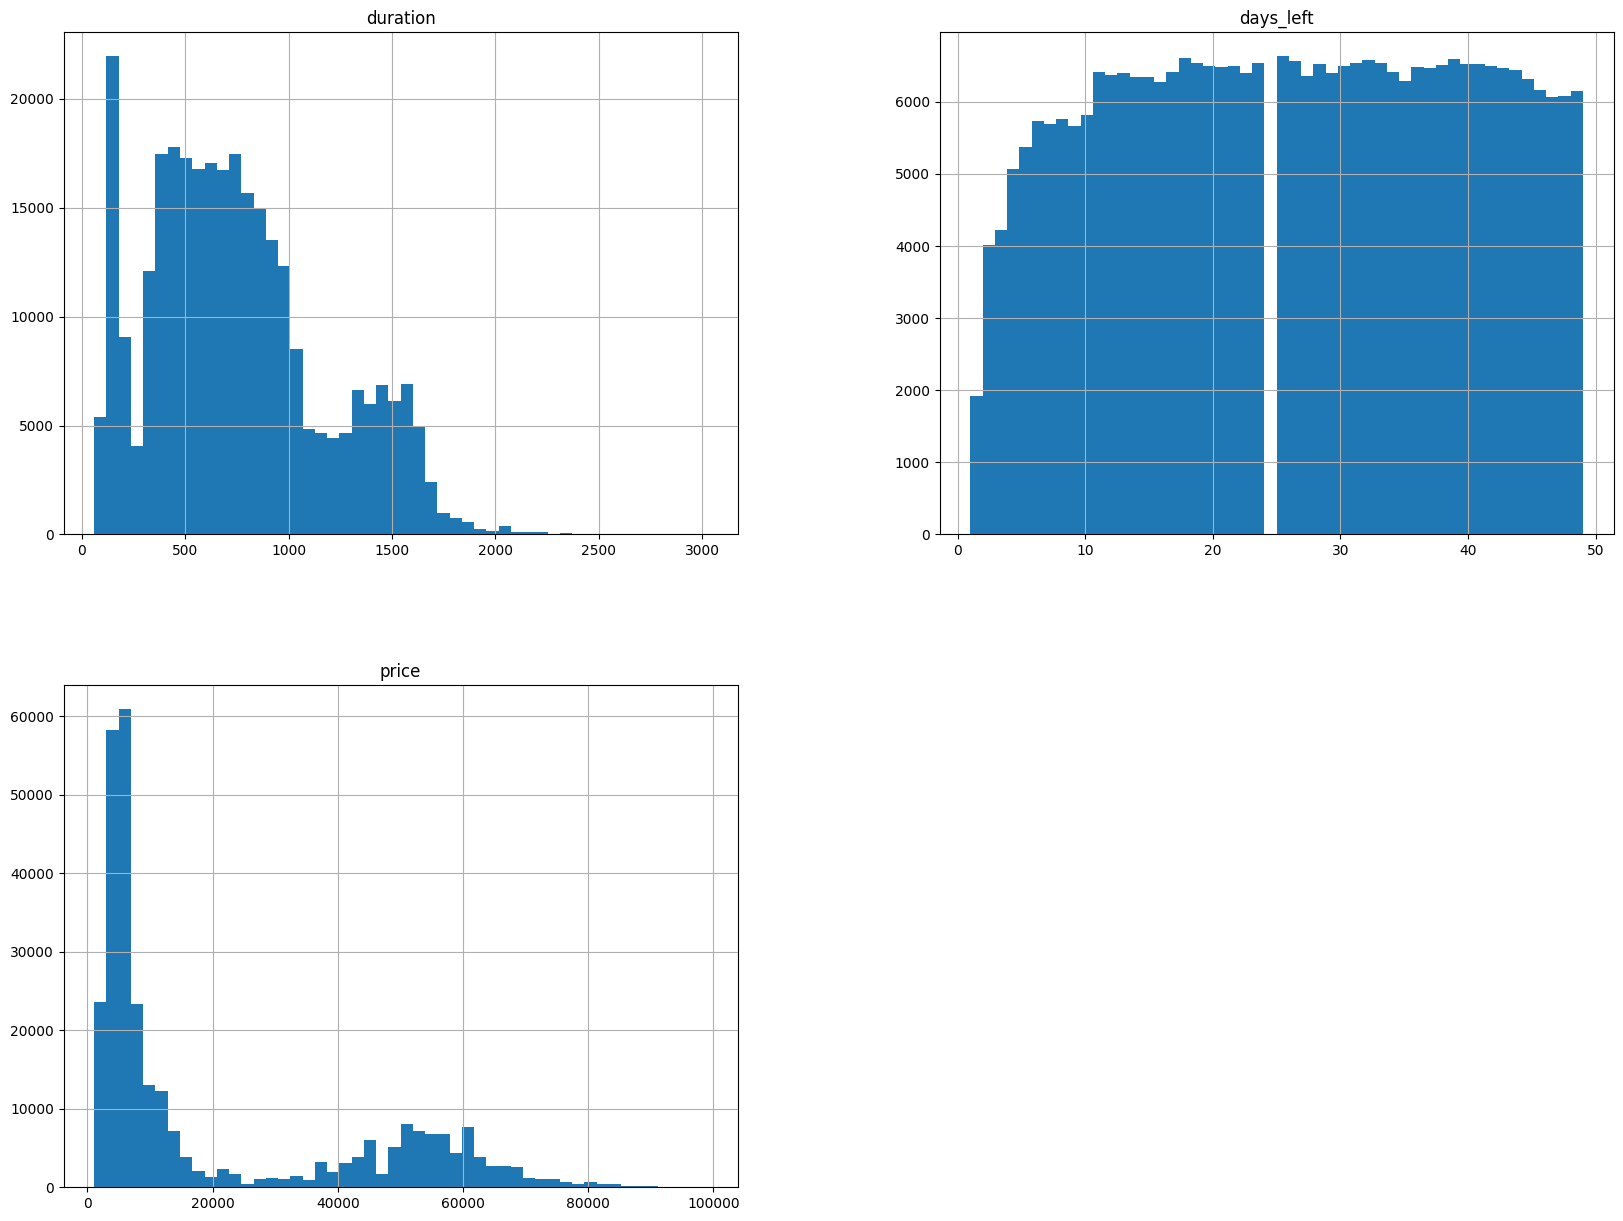

In [20]:
#check for the numerical distribution
numerical = df.select_dtypes(include='number').columns
df.hist(bins=50, figsize=(20,15))

### How our variables relate to price

**Important** currency is rupees (INR). 

1 INR == 0.012 USD

#### **1. How is price affected by the days left until plane departure?**

In the following plot, we want to **visualize through a line plot the price trend by varying the number of days left until flight departure**.

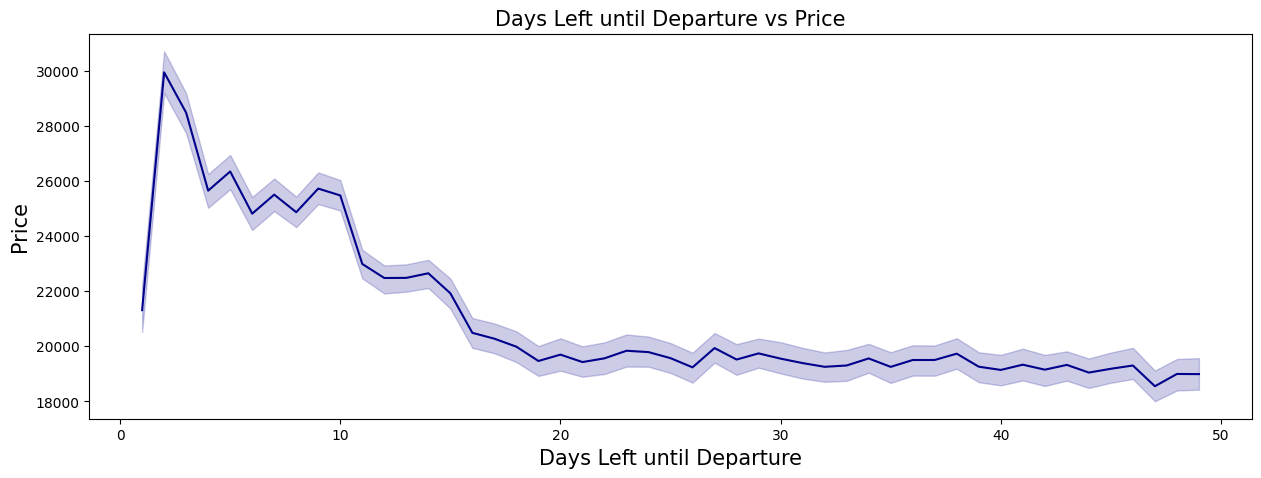

In [21]:
plt.figure(figsize = (15,5))
sns.lineplot(data = df, x = 'days_left', y = 'price', color = 'darkblue')
plt.title('Days Left until Departure vs Price', fontsize = 15)
plt.xlabel('Days Left until Departure', fontsize = 15)
plt.ylabel('Price', fontsize = 15)
plt.show()

We want to visualise this **same trend even for each single route**.

In [22]:
dl = df.groupby(['source_city', 'destination_city', 'days_left']).mean('price')
dl = dl.reset_index()
dl['route'] = dl['source_city'] + ' to ' + dl['destination_city']
dl.head()

,source_city,destination_city,days_left,duration,price,route
0,Bangalore,Chennai,1,1105.605263,22647.710526,Bangalore to Chennai
1,Bangalore,Chennai,2,1053.219780,32438.043956,Bangalore to Chennai
2,Bangalore,Chennai,3,1033.364583,30463.322917,Bangalore to Chennai
3,Bangalore,Chennai,4,964.804124,25613.474227,Bangalore to Chennai
4,Bangalore,Chennai,5,929.211864,24440.059322,Bangalore to Chennai


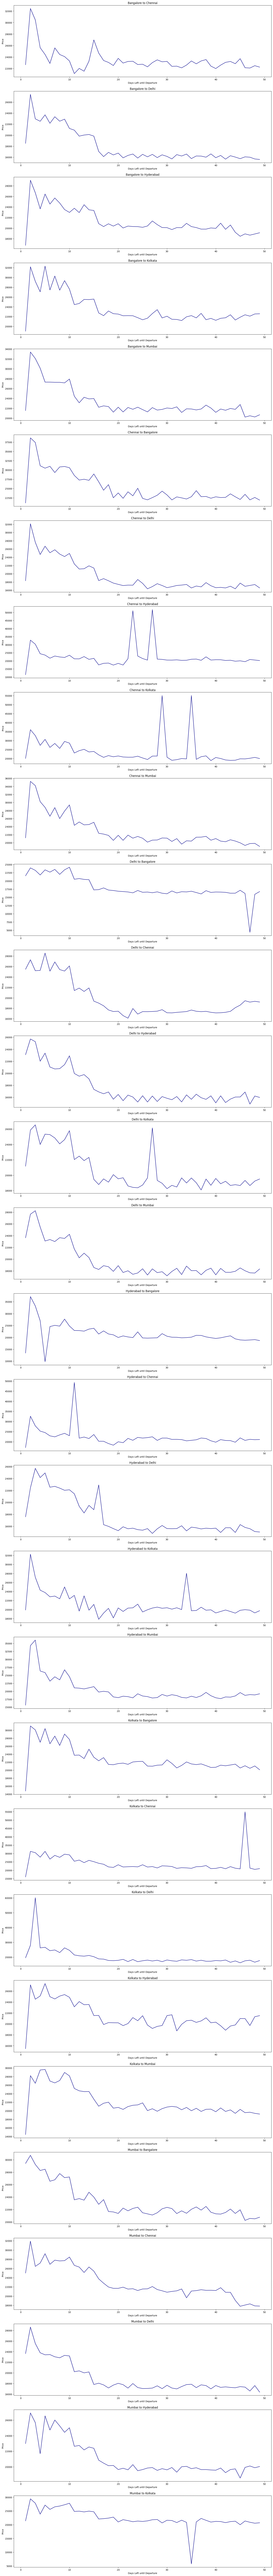

In [23]:
plt.figure(figsize=(20, 200))
for indx, val in enumerate(dl.route.unique()):
    plt.subplot(30, 1, indx + 1)
    temp_df = dl.loc[dl['route'] == val]
    sns.lineplot(data = temp_df, x = temp_df['days_left'], y = temp_df['price'], color = 'darkblue')
    plt.title(val)
    plt.xlabel('Days Left until Departure')
    plt.ylabel('Price')

##### In conclusion, generally, when purchasing a ticket well in advance of departure, prices are lower, and they rise as the number of days until departure decreases. Moreover, one day prior to departure, costs decrease.

#### **2. Is price affected by the source and destination city?**

To answer this question, we decided to realize a **relational plot** with seaborn, with price on the y axis and the various destination cities on the x axis. Each plot refers to a different source city: for example the first plot from the left shows how price variates going from Dehli to each of the others cities in the dataset.

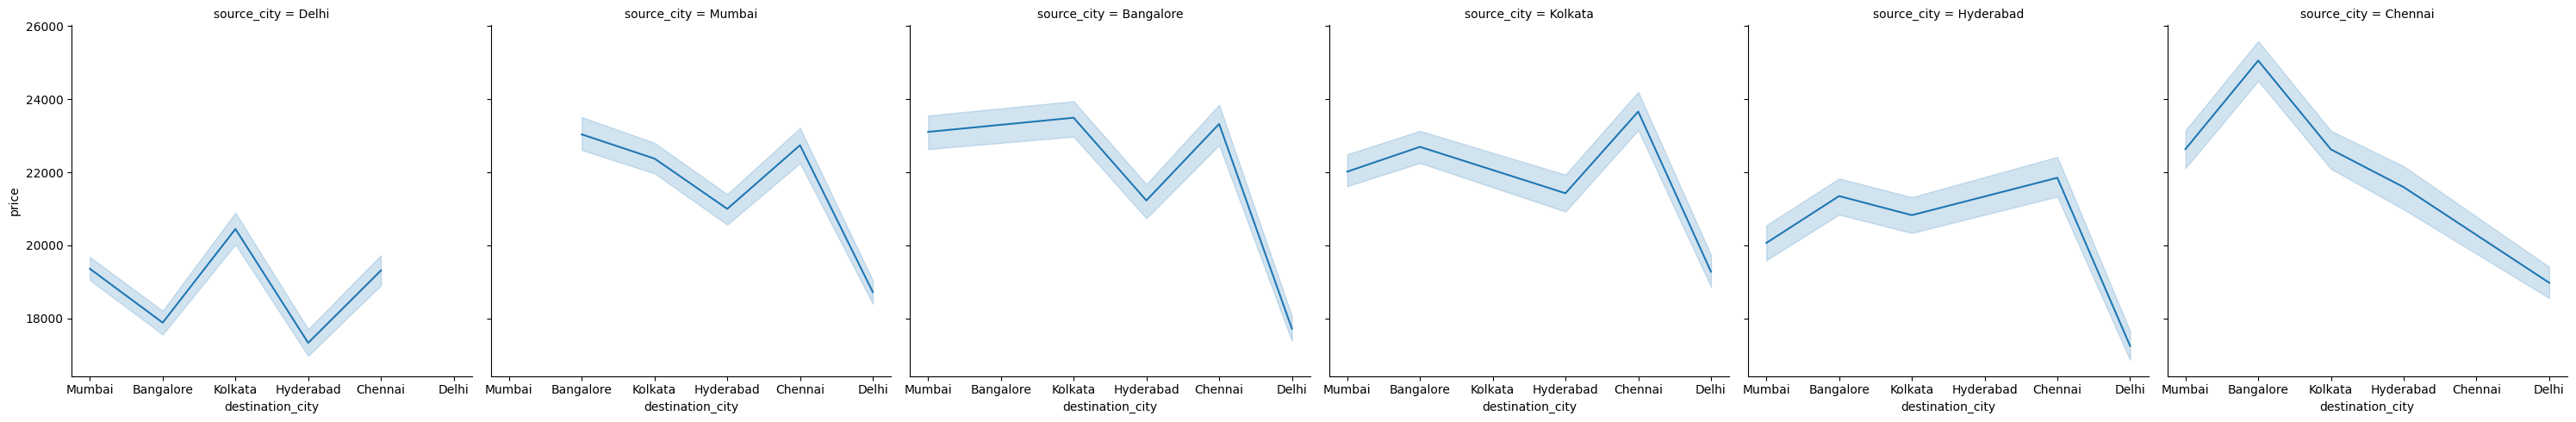

In [24]:
g = sns.relplot(col = "source_city", y = "price", kind = "line", x = 'destination_city', data = df)

##### It can be said that price is affected by source and destination cities; for example, we can see how more expesive it is from Chennai to go to Bangalore than to Delhi.

#### **3. How does the airfare vary between Economy and Business class?**

In this case we chose a **simple bar plot to show the difference in fares between economy and business tickets**.

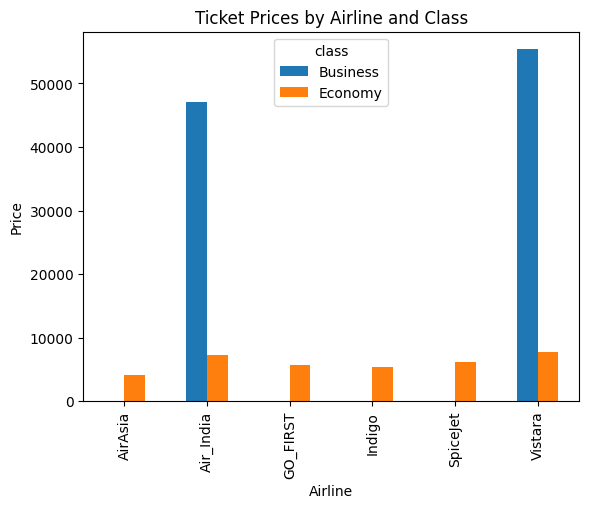

In [25]:
grouped = df.groupby(['airline', 'class']).mean('price')
# we create a pivot table with airlines as rows and classes as columns, and filled it with mean prices found in the previous step
pivot = pd.pivot_table(grouped, values='price', index=['airline'], columns=['class'])

pivot.plot(kind='bar')
plt.title('Ticket Prices by Airline and Class')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.show()

##### Not all the airlines offer business class tickets. 
##### Of course, business class tickets are much more expensive than economy ones.

#### **4. Is price affected by departure time and arrival time?**

To answer this question we decided to use the **seaborn categorical plots, that show the relationship between a numerical variable (_price_) and a categorical variable (_departure time_ in the first plot and _arrival time_ in the second) using the bar plot representation**.

First, we created a **dataset without the business class tickets**, that, as we have just seen, are only offered by two airlines and we analyzed how economy class tickets' price varies across airlines, first by time of departure then arrival.

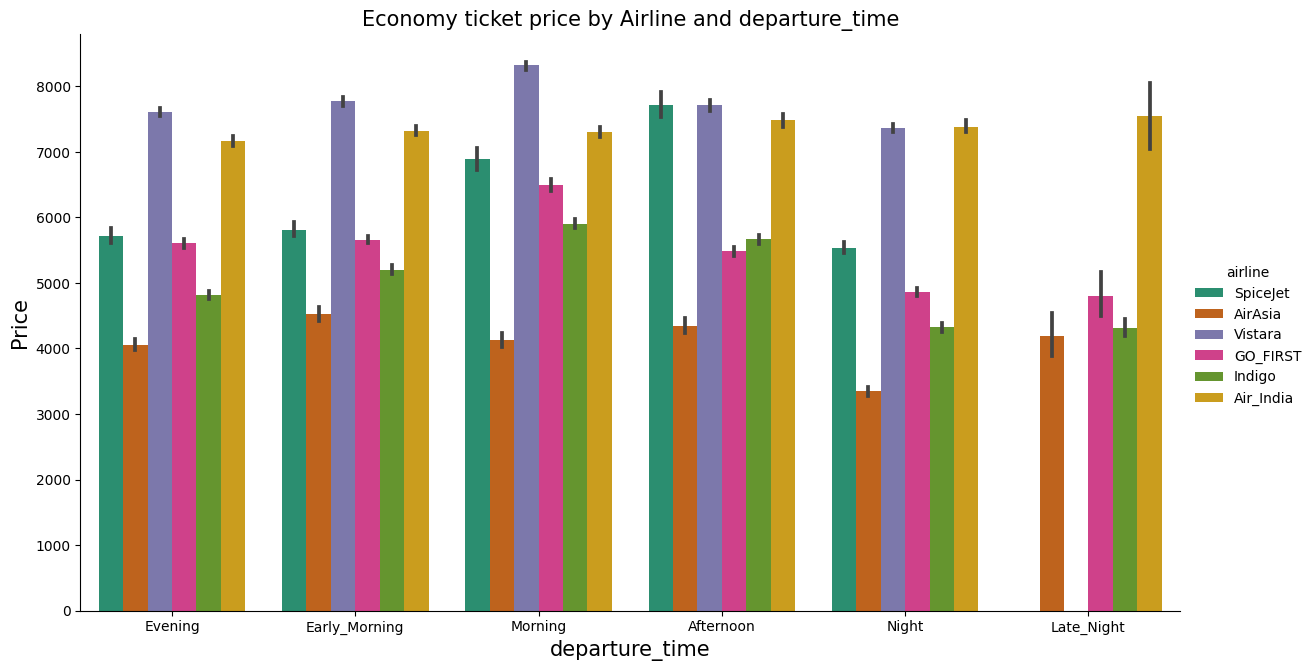

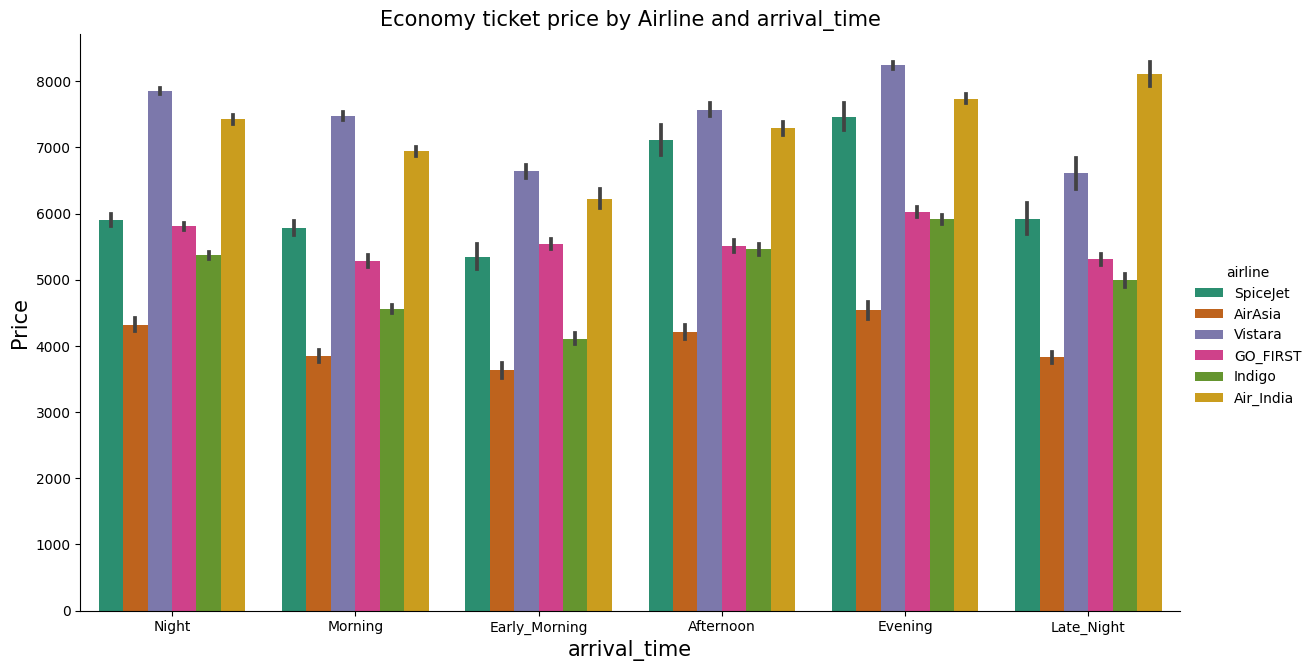

In [26]:
economy = df[df['class']=='Economy']
for el in ["departure_time", "arrival_time"]:
    sns.catplot(data=economy, kind="bar", x=el, y="price", hue="airline", height=6.5, aspect=12/6.5 ,palette='Dark2')
    plt.title(f'Economy ticket price by Airline and {el}',fontsize=15)
    plt.xlabel(f'{el}',fontsize=15)
    plt.ylabel('Price',fontsize=15)
    plt.show()

##### In this case, it is not possible to draw a clear conclusion, since it varies from airline to airline.

#### **5. How does the airfare vary with the number of stops?**

Finally, we wanted to check whether a relationship between airfare and the number of stops exists. And to do this we realized a **simple bar plot** with price on the y axis and airlines on the x axis, with bars coloured according to the number of stops. 

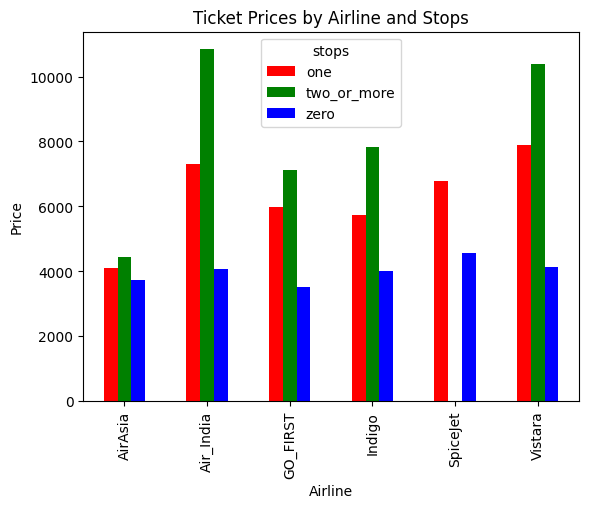

In [27]:
grouped = economy.groupby(['airline', 'stops']).mean('price')
# we created a pivot table with airlines as rows and classes as columns, and filled it with mean prices obtained in the previous step
pivot = pd.pivot_table(grouped, values='price', index=['airline'], columns=['stops'])

pivot.plot(kind='bar', color = "rgb")
plt.title('Ticket Prices by Airline and Stops')
plt.xlabel('Airline')
plt.ylabel('Price')
plt.show()

##### Overall, routes entailing two or more stops seems to be the most expensive ones, while the direct flights seems to be the cheapest.

# 3. Select appropriate features for your model, and transform the data as necessary to prepare it for modeling.

We have already converted duration into minutes. 

Now, as we could see from the correlation matrix, since **flight and airline are perfectly positively correlated**, we decided to drop the variable _flight_.

In [6]:
df = df.drop(["flight"], axis = 1)

We then calculated the haversine distances, using vectorized operations from numpy for computational efficiency, between each source and destination city pair. The haversine formula, which computes great-circle distances between two points on a sphere from their longitudes and latitudes, was particularly suitable in our context for calculating Earth distances between cities. In order to do so, Nominatim, from geopy, was used to extract geographical coordinates.

In [7]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

source_city = df['source_city'].unique().tolist()
destination_city = df['destination_city'].unique().tolist()

# Get the unique cities
cities = list(set(source_city + destination_city))

# Create a dictionary for the coordinates
city_dict = {}
geolocator = Nominatim(user_agent="geoapiExercises")

for city in cities:
    try:
        location = geolocator.geocode(city)
        if location is not None:
            city_dict[city] = {'Latitude': location.latitude, 'Longitude': location.longitude}
    except GeocoderTimedOut:
        continue

# Map the coordinates to the source and destination cities
df['source_lat'] = df['source_city'].map(lambda x: city_dict.get(x, {}).get('Latitude'))
df['source_long'] = df['source_city'].map(lambda x: city_dict.get(x, {}).get('Longitude'))
df['destination_lat'] = df['destination_city'].map(lambda x: city_dict.get(x, {}).get('Latitude'))
df['destination_long'] = df['destination_city'].map(lambda x: city_dict.get(x, {}).get('Longitude'))

# Define the haversine_distance function
def haversine_distance(lat1, lon1, lat2, lon2):
    # Convert coordinates to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371  # Radius of earth in kilometers
    return c * r

# Calculate the haversine distance
df['haversine_distance'] = haversine_distance(df['source_lat'], df['source_long'], df['destination_lat'], df['destination_long'])
df = df.drop(['source_lat','source_long','destination_lat','destination_long'], axis=1)

Let's get a quick description of the data.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300030 entries, 0 to 300152
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   airline             300030 non-null  object 
 1   source_city         300030 non-null  object 
 2   departure_time      300030 non-null  object 
 3   stops               300030 non-null  object 
 4   arrival_time        300030 non-null  object 
 5   destination_city    300030 non-null  object 
 6   class               300030 non-null  object 
 7   duration            300030 non-null  int64  
 8   days_left           300030 non-null  int64  
 9   price               300030 non-null  int64  
 10  haversine_distance  300030 non-null  float64
dtypes: float64(1), int64(3), object(7)
memory usage: 27.5+ MB


Finally, we will convert the non-numeric variables into categorical.

In [9]:
#extract the categorical features
cats = df.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    df[col] = df[col].astype('category')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300030 entries, 0 to 300152
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype   
---  ------            --------------   -----   
 0   airline           300030 non-null  category
 1   source_city       300030 non-null  category
 2   departure_time    300030 non-null  category
 3   stops             300030 non-null  category
 4   arrival_time      300030 non-null  category
 5   destination_city  300030 non-null  category
 6   class             300030 non-null  category
 7   duration          300030 non-null  int64   
 8   days_left         300030 non-null  int64   
 9   price             300030 non-null  int64   
dtypes: category(7), int64(3)
memory usage: 11.2 MB


# 4. Split the data into training and testing sets.

In the code below we imported the **needed sklearn libraries to prepare our data for modeling**: in particular to split our data into train and test sets and to preprocess them. 
Moreover, we also imported some **metrics** that we will use to evaluate the performance of our models.

In [10]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score

from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error,mean_absolute_percentage_error, r2_score
from sklearn.compose import make_column_transformer

We set _price_ to be our target variable and we perform 75% train and 25% test splitting.

In [11]:
X = df.copy().drop(columns='price')
y = df['price']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# 5. Train and evaluate at least 3 regression models, using appropriate metrics to assess their performance.

### FIRST BENCHMARK: LINEAR REGRESSION

This code creates a **machine learning pipeline for Linear Regression**. It first separates numerical and categorical features, then **standardizes numerical values and one-hot encodes categories**.

**Linear Regression was chose as benchmark model due to its simplicity and interpretability**. Additionally, it helps establish a baseline performance, enabling us to see how much more accuracy can be gained by using more complex models.

In [13]:
from sklearn.linear_model import LinearRegression

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

#create a pipeline for LINEAR regression
numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


model = LinearRegression()
lr_pipeline = Pipeline(steps=
                      [('pre', full_preprocessor),
                      ('model', model)])

lr_model = lr_pipeline.fit(X_train, y_train)

#predict and evaluate the model
y_pred_lr = lr_model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred_lr))
print('R2: ', r2_score(y_test, y_pred_lr))

MAE: 4553.6743859214275
RMSE:  6712.87719337558
MAPE:  0.4619547357185387
R2:  0.9121798137771004


### Linear Regression with Polynomial Features

This code applies a similar pipeline as before, but it introduces **polynomial features for numerical data**. These features can help model non-linear relationships in the data, potentially improving prediction accuracy.

In [14]:
numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

#create a pipeline for LINEAR regression
numerical_transformer = Pipeline(steps=
                                 [('poly', PolynomialFeatures(degree=2)),
                                  ('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


model = LinearRegression()
lr_pipeline = Pipeline(steps=
                      [('pre', full_preprocessor),
                      ('model', model)])

lr_model = lr_pipeline.fit(X_train, y_train)

#predict and evaluate the model
y_pred_lr = lr_model.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_lr))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_lr)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred_lr))
print('R2: ', r2_score(y_test, y_pred_lr))

MAE: 4436.739266144945
RMSE:  6597.635914501827
MAPE:  0.4464473776065998
R2:  0.9151691847688955


The model's performance has slightly improved with Polynomial Regression, which can model more complex relationships. However, this complexity increases the **risk of overfitting**. Given the minimal performance gain, it might be **preferable to prioritize the simpler, more interpretable Linear Regression**.

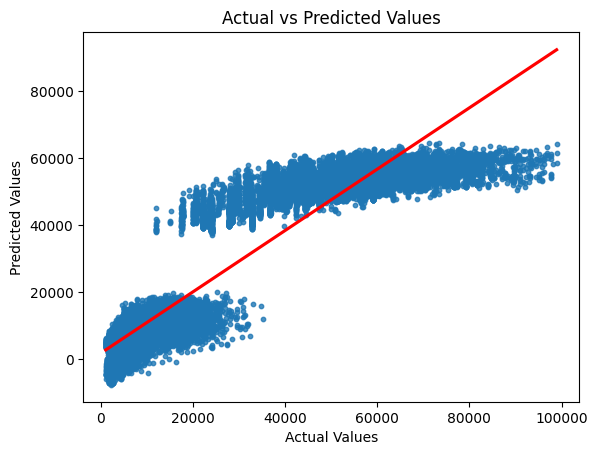

In [25]:
sns.regplot(x=y_test, y=y_pred_lr, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.savefig('actual_vs_predicted.png')
plt.show()

### RIDGE REGRESSION

This code is similar to the previous ones but uses **Ridge Regression**, a type of linear regression that includes a **regularization term** which introduce a degree of bias into the model, improving its generalization. The pipeline preprocesses the data - **standardizing numerical features and one-hot encoding categorical ones** - and then fits a Ridge Regression model to the processed training data. The trained model is used to predict the outcomes for the test set.

In [15]:
from sklearn.linear_model import Ridge # Ridge algorithm

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

#create a pipeline for LINEAR regression
numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


model = Ridge()
ridge_pipeline = Pipeline(steps=
                      [('pre', full_preprocessor),
                      ('model', model)])

ridge_pipeline.fit(X_train, y_train)

#predict and evaluate the model
ridge_y_pred = ridge_pipeline.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, ridge_y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, ridge_y_pred)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, ridge_y_pred))
print('R2: ', r2_score(y_test, ridge_y_pred))

MAE: 4553.625705774619
RMSE:  6712.881428525352
MAPE:  0.4619297797943802
R2:  0.9121797029656709


### LASSO REGRESSION

This code creates a machine learning pipeline using **Lasso Regression**. Lasso uses an L1 penalty which can shrink some of the model's coefficients to zero, effectively excluding those features from the model. This can be particularly useful when dealing with datasets that have a large number of features.
The pipeline preprocesses the data by **standardizing numerical features and one-hot encoding categorical ones**. The Lasso model is then trained on the preprocessed training data. The trained model is subsequently used to predict the outcomes for the test set.

In [27]:
from sklearn.linear_model import Lasso # Lasso algorithm

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

#create a pipeline for LINEAR regression
numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


model = Lasso()
lasso_pipeline = Pipeline(steps=
                      [('pre', full_preprocessor),
                      ('model', model)])

lasso_pipeline.fit(X_train, y_train)

#predict and evaluate the model
lasso_y_pred = lasso_pipeline.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, lasso_y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, lasso_y_pred)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, lasso_y_pred))
print('R2: ', r2_score(y_test, lasso_y_pred))

MAE: 4529.433382628836
RMSE:  6668.531206373324
MAPE:  0.4606061026393509
R2:  0.9132323106298503


### Compare the different linear models 

This code builds a pipeline to preprocess data and trains various linear models (Linear Regression, Ridge, Lasso) on the processed data. It standardizes numerical features and one-hot encodes categorical features. **Each model is evaluated using 6-fold cross-validation**. The cross-validation scores are collected and displayed as a boxplot for comparison.
The cross-validation scores are displayed as a boxplot to provide a visual comparison of the models' performances. Each boxplot represents the distribution of scores for one model, showing the median, quartiles, and potential outliers. This allows for a more **comprehensive comparison than just looking at single metric values**. From the previous example, we've moved from evaluating a single model's performance on a test set to comparing multiple models' performances using cross-validation, which provides a better estimate of how the models might perform on unseen data.

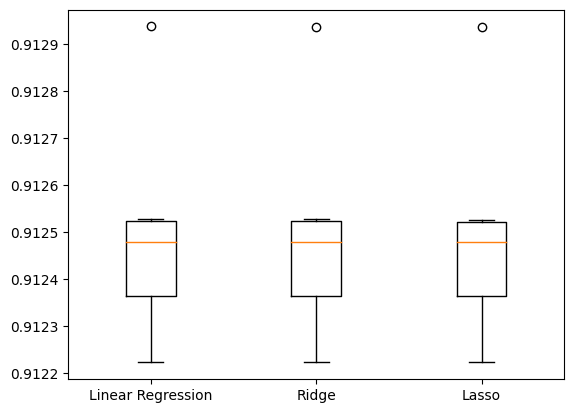

In [28]:
#create a pipeline for LINEAR regression
numerical_transformer = Pipeline(steps=
                                 [ ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])

models = {"Linear Regression": LinearRegression(), "Ridge": Ridge(), "Lasso": Lasso()}
results = []

for name, model in models.items():
    model_pipeline = Pipeline(steps=
                              [('pre', full_preprocessor),
                               ('model', model)])

    model_fit = model_pipeline.fit(X_train, y_train)

    kf = KFold(n_splits=6, random_state=42, shuffle=True)
    cv_scores = cross_val_score(model_fit, X_train, y_train, cv=kf)
    results.append(cv_scores)

plt.boxplot(results, labels=models.keys())
plt.show()

### SVR

**Support Vector Regression** is chosen in this scenario because it can handle non-linearities in the data, even though a linear kernel is used here. SVR attempts to fit the best line within a predefined margin of error, and it's robust to outliers. This can make SVR a good choice for regression problems where a robust model is required or where the data may not be perfectly linear.

In [29]:
from sklearn.svm import SVR

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


svr_model = SVR(kernel='linear')

svr_pipeline = Pipeline(steps=[
    ('pre', full_preprocessor),
    ('model', svr_model)
])

svr_pipeline.fit(X_train, y_train)

#predict and evaluate the model
y_pred_svr = svr_pipeline.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_svr))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_svr)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred_svr))
print('R2: ', r2_score(y_test, y_pred_svr))

MAE: 4325.596643016057
RMSE:  7205.287595048828
MAPE:  0.29902434326826666
R2:  0.8987021338883249


However, the SVR couldn't outperform Linear Regression. Hence, let's move on with more complex models.

## RANDOM FOREST AND XGBOOST

### RANDOM FOREST REGRESSOR

**Random Forest** is a versatile and robust machine learning algorithm that can handle both regression and classification tasks. It's an **ensemble method that builds multiple decision trees and aggregates their results**. This often results in a model with good predictive performance and robustness against overfitting.
This code constructs a **machine learning pipeline using a Random Forest Regressor**. The data preprocessing steps remain the same - **standardizing numerical features and one-hot encoding categorical ones**. The Random Forest Regressor is then trained on the preprocessed training data and evaluate on the preprocessed test data.

In [16]:
from sklearn.ensemble import RandomForestRegressor

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('num', numerical_transformer, numerical_features),
                                   ('cat', categorical_transformer, categorical_features)])


rfregr = RandomForestRegressor(random_state=42)

rf_pipeline = Pipeline(steps=[
    ('pre', full_preprocessor),
    ('model', rfregr)
])

rf_pipeline.fit(X_train, y_train)

#predict and evaluate the model
y_pred_rf = rf_pipeline.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_rf))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_rf)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred_rf))
print('R2: ', r2_score(y_test, y_pred_rf))

MAE: 1082.5138325148348
RMSE:  2712.6961675220705
MAPE:  0.06988606791687779
R2:  0.9856590059061094


### XGBOOST REGRESSOR

XGBoost (Extreme Gradient Boosting) is a powerful ensemble machine learning algorithm that uses gradient boosting framework. It has gained popularity due to its speed and performance. XGBoost builds multiple decision trees sequentially, where each new tree aims to correct the errors made by the previously trained tree. This can result in a model with excellent predictive performance.
This code constructs a machine learning pipeline using an XGBoost Regressor. The pipeline preprocesses the data - one-hot encoding categorical ones - and then fits an XGBoost Regressor to the processed training data. The trained model is used to predict the outcomes for the test set.

In [18]:
import xgboost as xgb

numerical_features = X_train.select_dtypes(include='number').columns.tolist()
categorical_features = X_train.select_dtypes(exclude='number').columns.tolist()

numerical_transformer = Pipeline(steps=
                                 [('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=
                                   [('onehot', OneHotEncoder(handle_unknown='ignore'))])


full_preprocessor = ColumnTransformer([('cat', categorical_transformer, categorical_features)])


xgb_r = xgb.XGBRegressor()

xgb_pipeline = Pipeline(steps=[
    ('pre', full_preprocessor),
    ('model', xgb_r)
])

xgb_pipeline.fit(X_train, y_train)

#predict and evaluate the model
y_pred_xg = xgb_pipeline.predict(X_test)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_xg))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred_xg)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred_xg))
print('R2: ', r2_score(y_test, y_pred_xg))

MAE: 3010.3985082972986
RMSE:  4599.017583842363
MAPE:  0.28574145508106724
R2:  0.9587800852341285


### XGBoost with DMatrices

This code follows a different pattern from the previous ones as it uses the native API of XGBoost, rather than the scikit-learn API. The data is transformed into DMatrix format, which is an optimized data structure that XGBoost uses for efficient training. The enable_categorical=True parameter is used to handle categorical variables directly in XGBoost without needing to one-hot encode them. The hyperparameters for the model are set to use the squared error loss function, suitable for regression tasks.

In [19]:
#convert data into DMatrix
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [20]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n)

#predict and evaluate the model
y_pred = model.predict(dtest_reg)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

MAE: 1386.5687957111709
RMSE:  2592.9380039338357
MAPE:  0.1098935045210007
R2:  0.986897287389419


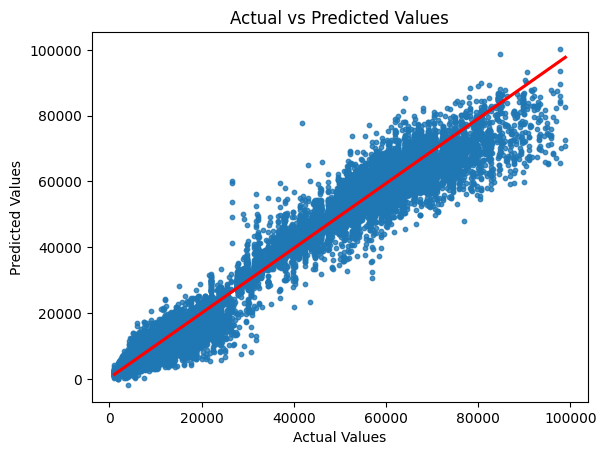

In [34]:
# In the above graph, the results of XGBOOST are visualized using a regplot to plot the residuals of a linear regression model. 
sns.regplot(x=y_test, y=y_pred, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.savefig('actual_vs_predicted.png')
plt.show()

### Feature importance

#### XGBOOST FEATURE IMPORTANCE

The provided code snippet creates three types of feature importance plots for an XGBoost model using Python's matplotlib library for visualizations and the plot_importance function from XGBoost.
Each plot visualizes a different type of feature importance:
- weight: the number of times a feature appears in a tree across all trees in the model. This plot gives us an idea about which features are most frequently used in the splits.
- gain: the average gain of a feature when it is used in trees. This plot shows the average contribution of the feature to the model across all trees, which can be interpreted as the improvement in accuracy brought by a feature to the splits it is involved in.
- cover: the average coverage of a feature when it is used in trees. This plot illustrates how many data points are affected by splits that a feature is involved in, on average.

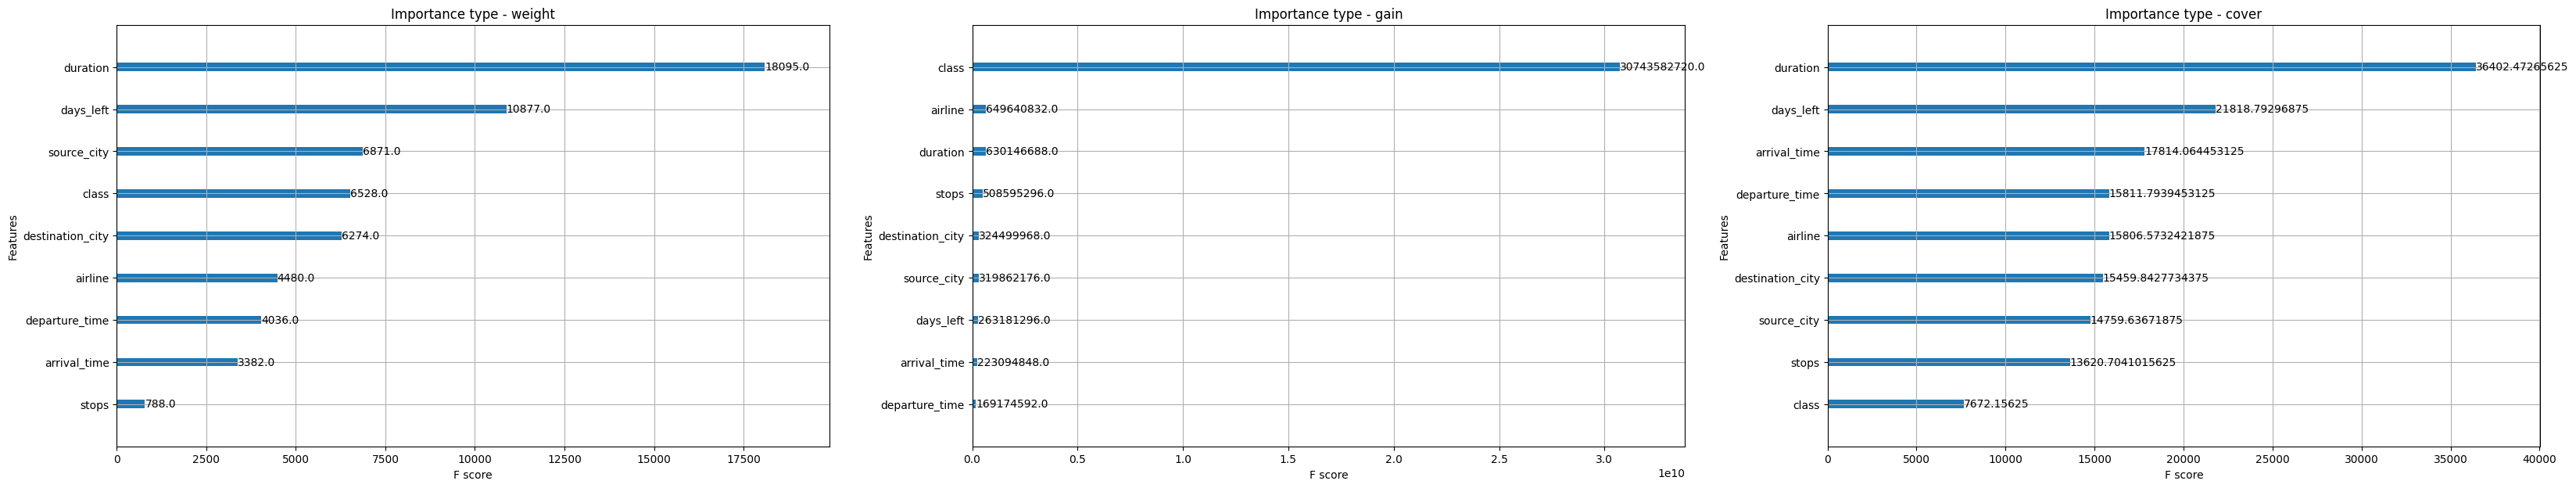

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(40, 7))

for ax, imp_type in zip(axes.flatten(), ["weight", "gain", "cover"]):
    xgb.plot_importance(
        model,
        ax=ax,
        importance_type=imp_type,
        title=f"Importance type - {imp_type}",
    )
plt.savefig('featureimp.png')
plt.show()

#### SHAP FEATURE IMPORTANCE

SHAP provides a more detailed view of feature importance and feature effects, taking into account not just the global importance of features, but also how features influence the prediction on an individual instance level. This can provide a more nuanced understanding of model's behavior, which is crucial when interpreting your model's decisions. The code below creates a SHAP explainer object for the trained model. An explainer is an object that can compute SHAP values for a particular model.  The, the SHAP values are computed for each feature for each sample in the provided dataset. 

In [36]:
import shap

SystemError: initialization of _internal failed without raising an exception

In [ ]:
explainer = shap.Explainer(model)
shap_values = explainer(dtrain_reg)

In [66]:
f = plt.figure()
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")
f.savefig("summary_plot.png", bbox_inches='tight', dpi=600)

NameError: name 'shap' is not defined

<Figure size 640x480 with 0 Axes>

### XGBOOST with Dmatrices and Feature Selection based on SHAP values

In [37]:
# 'arrival_time', 'departure_time' are dropped, since they are the less important features according to SHAP
X, y = df.drop(['price', 'arrival_time', 'departure_time'], axis=1), df[['price']]

#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

#convert data into DMatrix
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [39]:
# Define hyperparameters
params = {"objective": "reg:squarederror"}

n = 1000
model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n)
#predict and evaluate the model
y_pred = model.predict(dtest_reg)

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, y_pred))
print('R2: ', r2_score(y_test, y_pred))

MAE: 1579.7376156934495
RMSE:  2922.457894461917
MAPE:  0.12084746618249913
R2:  0.9832683243770204


As it can be seen, after removing even the less important variables, the model performance worsen. 

## Bayesian Optimization for XGBOOST with Dmatrices
- After finding the XGBOOST with Dmatrices is the best model in predicting the Prices, it now possible to move on and tuning the model;
- In order to do so, the tuning is performed thanks to bayes_opt, a Python Library that allow the Bayesian Optimization of Models

Here, Bayesian optimization is implemented to fine-tune the hyperparameters of the XGBoost model. Bayesian optimization is a sequential design strategy for global optimization of black-box functions that works by constructing a posterior distribution of functions that best describes the function you want to optimize. The evaluation function xgb_eval is defined. This function sets up the parameters for the XGBoost model and runs cross-validation on the training data, with mean absolute error (MAE) as the evaluation metric. The function returns the negative of the minimum test MAE, because the Bayesian optimizer seeks to maximize the function it is given, and we want to minimize MAE.
This approach allows for more effective tuning of the XGBoost model's hyperparameters compared to manual tuning or grid search, especially when the number of hyperparameters and the complexity of the model make other approaches impractical or time-consuming.

In [21]:
X, y = df.drop('price', axis=1), df[['price']]

#extract the categorical features
cats = X.select_dtypes(exclude=np.number).columns.tolist()

# Convert to Pandas category
for col in cats:
    X[col] = X[col].astype('category')
    
#split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y)

#convert data into DMatrix
dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
dtest_reg = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [75]:
import xgboost as xgb
from bayes_opt import BayesianOptimization
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# Define XGBoost evaluation function
def xgb_eval(max_depth, gamma, min_child_weight, subsample, colsample_bytree, eta):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'gamma': gamma,
        'min_child_weight': min_child_weight,
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'eta': eta,
        'eval_metric': 'mae'
    }
    # early stopping and evaluate based on minimum mae
    result = xgb.cv(params, dtrain_reg, num_boost_round=1000, nfold=3, 
                     early_stopping_rounds=10, metrics="mae", as_pandas=True)

    return -result['test-mae-mean'].min()  

# define the function that performs the hyperparameter optimization
def optimize_xgb():
    def xgb_crossval(max_depth, gamma, min_child_weight, subsample, colsample_bytree,eta):
        return xgb_eval(
            max_depth=int(max_depth),
            gamma=gamma,
            min_child_weight=min_child_weight,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            eta = eta
           
        )

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        pbounds={
            "max_depth": (3, 10),
            "gamma": (0, 1),
            "min_child_weight": (0, 10),
            "subsample": (0.6, 1.0),
            "colsample_bytree": (0.6, 1.0),
            "eta":(0.01, 0.1)
            
            
        },
        verbose=2,
        allow_duplicate_points=True #so that if the optimizer converge to fast it do not raise an error
    )
    optimizer.maximize(n_iter=35, init_points=10)
    best_params = optimizer.max['params']
    best_params['max_depth'] = int(best_params['max_depth'])
    best_params['eval_metric'] = 'mae'
    return best_params
    print("Final result:", optimizer.max)

# run all
optimize_xgb()

|   iter    |  target   | colsam... |    eta    |   gamma   | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -2.319e+0 | 0.6801    | 0.0679    | 0.7797    | 4.925     | 6.473     | 0.8185    |
| 2         | -2.06e+03 | 0.7953    | 0.0567    | 0.3418    | 5.458     | 3.226     | 0.6657    |
| 3         | -1.553e+0 | 0.6488    | 0.03396   | 0.5605    | 9.258     | 8.153     | 0.6067    |
| 4         | -1.889e+0 | 0.8822    | 0.01014   | 0.1296    | 8.995     | 3.578     | 0.8148    |
| 5         | -2.378e+0 | 0.6606    | 0.05159   | 0.8971    | 4.935     | 4.833     | 0.8973    |
| 6         | -1.731e+0 | 0.9527    | 0.06328   | 0.1194    | 6.183     | 6.813     | 0.7597    |
| 7         | -1.482e+0 | 0.8718    | 0.09403   | 0.5561    | 7.832     | 2.729     | 0.7196    |
| 8         | -2.576e+0 | 0.968     | 0.07472   | 0.1385    | 3.401     | 8.613     | 0.8937    |
| 9         | -1.838

{'colsample_bytree': 1.0,
 'eta': 0.1,
 'gamma': 1.0,
 'max_depth': 10,
 'min_child_weight': 6.633015933841986,
 'subsample': 1.0,
 'eval_metric': 'mae'}

In [22]:
# This are the optimal parameters found with Bayesian Optimization
import xgboost as xgb
best_params = {
    'objective': 'reg:squarederror',
   'colsample_bytree': 1,
   'gamma': 1, 
   'max_depth': 10,
   'min_child_weight': 6.633015933841986,
    'eta': 0.1,
   'eval_metric': 'mae', 
   'subsample': 1}
# Train the model with the optimal parameters
model = xgb.train(best_params, dtrain_reg, num_boost_round=1000)

In [23]:
#predict and evaluate the model
predictions = model.predict(dtest_reg)
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('MAPE: ', metrics.mean_absolute_percentage_error(y_test, predictions))
print('R2: ', r2_score(y_test, predictions))

MAE: 1159.729681271335
RMSE:  2401.0780625492753
MAPE:  0.08455396690498566
R2:  0.9887168677303382


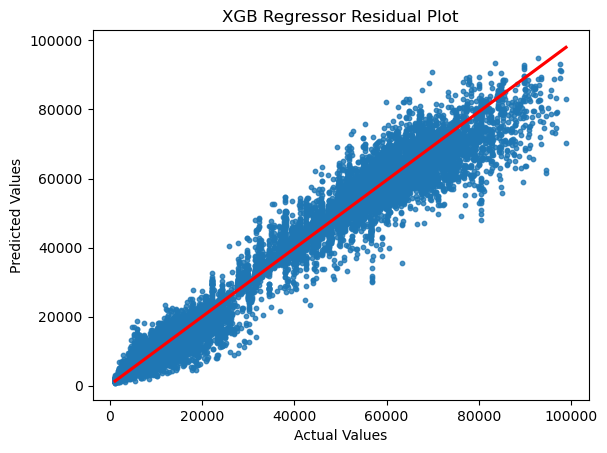

In [ ]:
sns.regplot(x=y_test, y=predictions, scatter_kws={'s': 10}, line_kws={'color': 'red'})
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('XGB Regressor Residual Plot')
plt.savefig('XGB_regressor_residual_plot.png')  # Saves the plot
plt.show()

This scatterplot, also known as a residual plot, illustrates the relationship between the actual and predicted values for our model. The red line denotes the ideal prediction line, where the actual values equal the predicted ones. As can be seen from the plot, the majority of data points are close to this line, indicating that our model's predictions are generally accurate.

In [ ]:
#let's see onece again the most important variables in the chosen model
import shap
explainer = shap.Explainer(model)
shap_values = explainer(dtest_reg)
f = plt.figure()
shap.summary_plot(shap_values, sample_dtest, feature_names=sample_dtest.columns, plot_type="bar")
f.savefig("summary_plot.png", bbox_inches='tight', dpi=600)